
# Simulador 2D liviano de registro sísmico

Sismica 2025- Universidad de los Andes - Departamento de Geociencias

Profesor: Miguel Lizarazo

Descripción:
- Construye modelos geológicos simples (capas horizontales, inclinadas, anticlinal/sinclinal) y fallas con salto.
- Genera:
  (1) Traza sísmica por convolución 1D (zero-offset) por cada x.
  (2) Un registro de tiro común (shot gather) con hiperbolas usando velocidad efectiva constante.
- Usa un modelo acústico simplificado: las amplitudes provienen de coeficientes de reflexión (impedancia acústica),
  y los tiempos de viaje se calculan con una velocidad efectiva constante para propagación (v_eff).

Requisitos: numpy, matplotlib

**Objetivo:** que puedas *entender* (desde cero) cómo se construye un registro sísmico sintético a partir de un modelo geológico muy simple, y que puedas **jugar** con los parámetros (geometría, velocidades, densidades, fuente) para ver cómo cambia el registro.

> Este cuaderno usa un modelo acústico simplificado para mantener todo **liviano** y **rápido** (ideal para clase).



## ¿Qué es un registro sísmico? 

Un **registro sísmico** es un conjunto de **trazas** (señales en función del tiempo) registradas por receptores cuando emitimos una **onda** (un pulso) en el suelo.  
La onda baja, **rebota** (se refleja) donde cambian las propiedades de las rocas (impedancia acústica) y vuelve a la superficie.  
Cada receptor graba una traza: amplitud vs. tiempo.

- **Amplitud**: qué tan fuerte es la señal en un instante.
- **Tiempo** (TWT, *Two-Way Time*): tiempo de ida y vuelta de la onda.
- **Trazas**: una por cada receptor. Si pones muchos receptores a lo largo de x, obtienes una **sección sísmica**.

En este cuaderno verás que con solo:
1) un **modelo de capas** (profundidad de interfaces y propiedades),
2) una **fuente** simple (onda de Ricker),
3) y una **velocidad efectiva** para tiempos de viaje,

¡puedes generar un **registro sintético** muy parecido a lo observado en campo!



## Flujo de trabajo (resumen)

1. **Definir la geometría**: interfaces \(z_i(x)\) que separan capas (horizontales, inclinadas, anticlinales, sinclinales, fallas con salto).
2. **Asignar propiedades** a cada capa: **velocidad** \(v\) y **densidad** \(\rho\). Se usa la **impedancia acústica** \(Z=\rho v\).
3. **Calcular reflectividades** en cada interfaz: \(R = \frac{Z_2 - Z_1}{Z_2 + Z_1}\).
4. **Fuente**: generar una onda sísmica (usaremos **Ricker**).
5. **Zero-offset**: ubicamos picos de reflectividad en \(t = 2z/v_{eff}\) y **convolucionamos** con la fuente.
6. **Tiro común (shot gather)**: para una fuente y muchos receptores, usamos **hipérbolas** de viaje \(t(h) = \tfrac{2}{v_{eff}}\sqrt{z^2+h^2}\).
7. **Post-procesamiento**: **AGC** para ver mejor amplitudes y **gráficas tipo wiggle** para interpretación.
8. **Interpretación**: identificar reflectores, curvatura hiperbólica, efectos de geometría y velocidad.


In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass



## Onda de Ricker y utilidades de señal

Qué es: un pulso banda limitada simétrico (parecido a un “sombrero mexicano”). Se usa como aproximación de la fuente sísmica.

Parámetro clave: 
𝑓: (frecuencia pico): define resolución (más alta ⇒ mejor detalle) y penetración (más baja ⇒ llega más profundo).

En el sintético: Al Convolucionar la serie de reflectividad con Ricker se obtienen trazas “realistas” sin ruido. Elegir f alto resalta detalles finos pero acorta penetración; 𝑓 bajo suaviza reflectores y aumenta continuidad.

En campo real El barrido/impulso real no es Ricker puro: hay atenuación, dispersión y ruido.

Estimación de la ondícula (wavelet) y su deconvolución son pasos clave para mejorar resolución.
- **Ricker**: pulso banda limitada típico en sísmica (parecido a una "onda sombrero mexicano").  
- **Convolución**: combina la **respuesta del terreno** (serie de reflectividad) con la **fuente** para obtener la **traza sintética**.  
- **AGC (Automatic Gain Control)**: ganancia automática para hacer visibles señales tardías.


In [2]:
def ricker(f, dt, nt):
    t = np.arange(nt) * dt
    t0 = (nt // 2) * dt
    tau = t - t0
    pf2 = (np.pi * f * tau) ** 2
    return (1 - 2 * pf2) * np.exp(-pf2)

def convolve_traces(traces, wavelet):
    nt, nx = traces.shape
    out = np.zeros((nt, nx))
    for ix in range(nx):
        out[:, ix] = np.convolve(traces[:, ix], wavelet, mode='same')
    return out

def agc(traces, win):
    nt, nx = traces.shape
    out = np.zeros_like(traces)
    eps = 1e-6
    ker = np.ones(win) / max(win, 1)
    for ix in range(nx):
        amp = np.sqrt(np.convolve(traces[:, ix]**2, ker, mode='same'))
        out[:, ix] = traces[:, ix] / (amp + eps)
    return out



## Visualización tipo *wiggle*
Las secciones sísmicas suelen mostrarse como **trazas** desplazadas en x, rellenando de un color (o gris) las **semiondas positivas**. Aquí hacemos una versión simple.


In [12]:
def wiggle(image, x, t, scale=1.0, fill=True, dx=1.0):
    nt, nx = image.shape
    im = image / (np.max(np.abs(image), axis=0, keepdims=True) + 1e-9)
    for i in range(nx):
        tr = im[:, i] * scale
        plt.plot(x[i] + tr * dx, t, linewidth=0.6)
        if fill:
            plt.fill_betweenx(t, x[i], x[i] + np.maximum(tr, 0) * dx, alpha=0.4, linewidth=0)



## Construyendo un modelo geológico 2D (capas e interfaces)
Representaremos el subsuelo con **interfaces** \(z_i(x)\) que separan **capas** con propiedades constantes.  
Añadiremos funciones para crear **horizontales**, **inclinadas**, **anticlinal/sinclinal** y **fallas** (saltos).


In [4]:
@dataclass
class Layer:
    v: float
    rho: float

class GeoModel2D:
    def __init__(self, x):
        self.x = x
        self.interfaces = []
        self.layers = []

    @staticmethod
    def horizontal(z):
        return lambda x: np.full_like(x, z, dtype=float)

    @staticmethod
    def inclinada(z0, dip_deg):
        dip = np.deg2rad(dip_deg)
        return lambda x: z0 + np.tan(dip) * (x - x[0])

    @staticmethod
    def anticlinal(z0, amplitud, ancho, x0):
        sigma = ancho / 2.355
        return lambda x: z0 - amplitud * np.exp(-((x - x0) ** 2) / (2 * sigma ** 2))

    @staticmethod
    def sinclinal(z0, amplitud, ancho, x0):
        sigma = ancho / 2.355
        return lambda x: z0 + amplitud * np.exp(-((x - x0) ** 2) / (2 * sigma ** 2))

    @staticmethod
    def aplicar_falla(z_func, x_fault, salto, lado="derecha"):
        def zf(x):
            z = z_func(x)
            if lado == "derecha":
                z = np.where(x >= x_fault, z + salto, z)
            else:
                z = np.where(x <= x_fault, z + salto, z)
            return z
        return zf

    def add_interface(self, z_func):
        self.interfaces.append(z_func)

    def set_layers(self, layers):
        assert len(layers) == len(self.interfaces) + 1, "Capas = interfaces + 1"
        self.layers = layers

    def get_interfaces_z(self):
        return [f(self.x) for f in self.interfaces]

    def reflectivity_series(self):
        Z = [ly.rho * ly.v for ly in self.layers]
        Rs, Zs = [], self.get_interfaces_z()
        for i in range(len(self.interfaces)):
            R = (Z[i+1] - Z[i]) / (Z[i+1] + Z[i])
            Rs.append(np.full_like(self.x, R, dtype=float))
        return Rs, Zs



## Síntesis: Zero-offset y Tiro común

Qué es: caso ideal donde fuente y receptor están colocalizados. El tiempo de un reflector a profundidad 

𝑡𝑍𝑂(𝑥)=2𝑧(𝑥)/𝑣eff

**Zero-offset:** como si fuente y receptor estuvieran juntos en cada x. Colocamos *impulsos* en los tiempos de las interfaces y **convolucionamos** con la Ricker.

En campo real No medimos ZO puro; se aproxima con pila (stack) tras NMO correcto. Esto es un reto en el procesamiento porque hay errores en velocidad, lo que genera staks mal aplanada, lo cual genera smiles/frowns (artefactos) y pérdida de continuidad.

**Tiro común (shot gather):** Es una fuente fija y muchos receptores; las reflexiones se ven como hipérbolas. Para ver los reflectores en su posicion real hay que corregir la hiperbola a traves de:

$$
t(h) = t_0^2 + \frac{4h^2}{v_{NMO}^2}, \quad h = \frac{x_r - x_s}{2}
$$

donde t0 es el tiempo a offset cero (ZO) y 𝑣NMO es la velocidad que aplana la hipérbola.

En el sintético: se ven las hipérbolas limpias controladas porque estan controladas por 𝑣eff. En la realidad es un reto porque estan las ondas directa, refractada (cabeza), ground roll, múltiples, ruido que no son hiperbolas y por tanto no se correigen con NMO. Para esto e hacen  análisis de velocidades mas avanzados(semblanza/velan).

**Velocidad efectiva veff(o de NMO / RMS “simple”)**: Es una velocidad equivalente que resume el efecto de capas en los tiempos de viaje (no necesariamente la verdadera local). En ZO simple usamos veff, en NMO se suele estimar 
𝑣NMO (relacionada con la velocidad RMS).

En el sintético veff controla la curvatura de hipérbolas y los tiempos ZO. Escogerla mal implica que las hipérbolas “no cierran” o ZO con tiempos sesgados.

En la practica se estima desde gathers (velan/semblance), si se usa mal sobre/infra-corrección NMO, hay pérdida de apilamiento, y eventos mal posicionados en la migración.


In [13]:
def zero_offset_section(model: GeoModel2D, v_eff, dt, tmax, f0, agc_win=None):
    nx = len(model.x)
    nt = int(tmax / dt) + 1
    sec = np.zeros((nt, nx))
    Rs, Zs = model.reflectivity_series()

    for R, z in zip(Rs, Zs):
        t_arr = 2.0 * z / v_eff
        it = np.clip((t_arr / dt).astype(int), 0, nt - 1)
        for ix in range(nx):
            sec[it[ix], ix] += R[ix]

    w = ricker(f0, dt, 201)
    sec = convolve_traces(sec, w)
    if agc_win:
        sec = agc(sec, agc_win)
    return sec

def shot_gather(model: GeoModel2D, v_eff, xs, xr, dt, tmax, f0, agc_win=None):
    nxr = len(xr)
    nt = int(tmax / dt) + 1
    rec = np.zeros((nt, nxr))
    Rs, Zs = model.reflectivity_series()

    for i in range(len(Zs)):
        R = Rs[i]
        z_interface = Zs[i]
        for j in range(nxr):
            xm = 0.5 * (xs + xr[j])
            z_m = np.interp(xm, model.x, z_interface)
            h = 0.5 * (xr[j] - xs)
            t = 2.0 * np.sqrt(z_m**2 + h**2) / v_eff
            it = int(np.round(t / dt))
            if 0 <= it < nt:
                rec[it, j] += np.interp(xm, model.x, R)

    w = ricker(f0, dt, 201)
    rec = convolve_traces(rec, w)
    if agc_win:
        rec = agc(rec, agc_win)
    return rec



## Construir y visualizar un modelo de ejemplo
En este ejemplo mezclamos:
- Una **horizontal** (z=400 m)
- Una **estructura** tipo **anticlinal** como segunda interfaz, con una **falla** normal de salto 120 m a la derecha de x=1300 m.

Luego dibujamos las interfaces (perfil de profundidad). Recuerda que en geología el **eje z aumenta hacia abajo**.


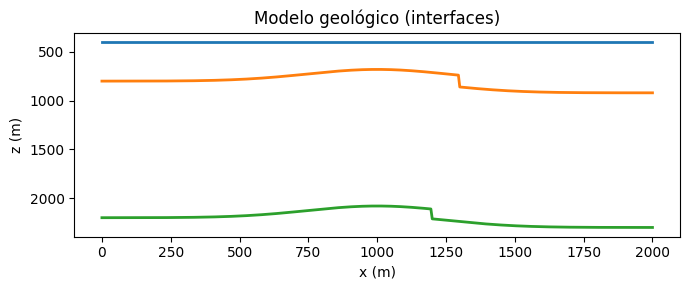

Interfaz 1: R ≈ 0.171
Interfaz 2: R ≈ 0.176
Interfaz 3: R ≈ 0.098


In [14]:
# Eje espacial
x = np.linspace(0, 2000, 401)  # cada 5 m

# Construcción geométrica
gm = GeoModel2D(x)

z1 = GeoModel2D.horizontal(400)
z2_base = GeoModel2D.anticlinal(z0=800, amplitud=120, ancho=600, x0=1000)
z2 = GeoModel2D.aplicar_falla(z2_base, x_fault=1300, salto=120, lado="derecha")
z3_base = GeoModel2D.anticlinal(z0=2200, amplitud=120, ancho=600, x0=1000)
z3 = GeoModel2D.aplicar_falla(z3_base, x_fault=1200, salto=100, lado="derecha")

gm.add_interface(z1)
gm.add_interface(z2)
gm.add_interface(z3)

# Capas (4 capas = 3 interfaces + 1)
layers = [
    Layer(v=1800, rho=1900),  # superior
    Layer(v=2300, rho=2100),
    Layer(v=3000, rho=2300),
    Layer(v=3500, rho=2400),  # inferior
]
gm.set_layers(layers)

# Visualización del modelo
plt.figure(figsize=(7,3))
for z in gm.get_interfaces_z():
    plt.plot(gm.x, z, linewidth=2)
plt.gca().invert_yaxis()
plt.xlabel('x (m)'); plt.ylabel('z (m)')
plt.title('Modelo geológico (interfaces)')
plt.tight_layout()
plt.show()

# Coeficientes de reflexión (constantes por interfaz en este modelo acústico)
Rs, Zs = gm.reflectivity_series()
for i, R in enumerate(Rs, start=1):
    print(f"Interfaz {i}: R ≈ {R[0]:.3f}")


## Sección zero-offset: idea e interpretación

- Colocamos **impulsos** en los tiempos \(t = 2z(x)/v_{eff}\) para cada interfaz.
- **Convolucionamos** con la Ricker (la tierra como una **serie de reflectividad**).
- Observa cómo la **geometría** (falla, anticlinal) **mueve** los tiempos.
- **AGC** ayuda a visualizar mejor amplitudes a tiempos tardíos (por atenuación y geometría).

Interpreta:
- Las **continuidades** indican interfaces más "planas".
- **Cortes** o **saltos** en los reflectores sugieren **fallas**.
- Cambios suaves en **tiempo** reflejan **inclinaciones** o **estructuras** (anticlinal/sinclinal).


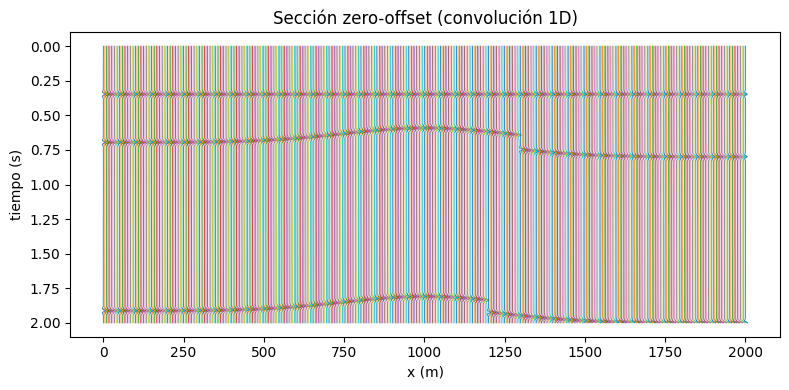

In [15]:
dt = 0.001; tmax = 2.0; f0 = 25.0; v_eff = 2300
zosec = zero_offset_section(gm, v_eff=v_eff, dt=dt, tmax=tmax, f0=f0, agc_win=121)

t = np.arange(zosec.shape[0]) * dt
plt.figure(figsize=(8,4))
wiggle(zosec, x=gm.x, t=t, scale=0.9, fill=True, dx=8)
plt.gca().invert_yaxis()
plt.xlabel('x (m)'); plt.ylabel('tiempo (s)')
plt.title('Sección zero-offset (convolución 1D)')
plt.tight_layout(); plt.show()


## Tiro común (shot gather): hipérbolas y velocidad efectiva

- Fijamos una **fuente** en \(x_s\) y varios **receptores** \(x_r\).
- Para un reflector a profundidad \(z(x_m)\) (en el **punto medio** \(x_m=\tfrac{x_s+x_r}{2}\)), el tiempo de llegada es
\[ t(h) = \frac{2}{v_{eff}}\sqrt{z(x_m)^2 + h^2}, \quad h = \tfrac{x_r-x_s}{2}. \]
- Esto genera **hipérbolas**. La curvatura depende de \(v_{eff}\) y \(z\).

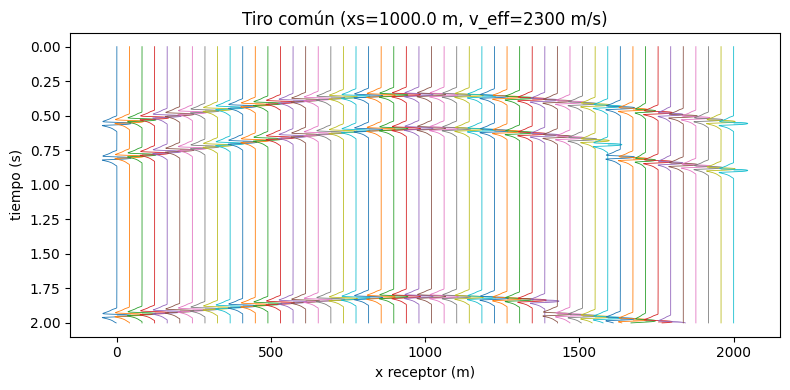

In [19]:
xs = 1000.0 #posicion de la fuente
nR = 50 # numero de receptores
xr = np.linspace(0, 2000, nR)  # receptores
amplitud=5.9 # amplitud grafica del reflector

sg = shot_gather(gm, v_eff=v_eff, xs=xs, xr=xr, dt=dt, tmax=tmax, f0=f0, agc_win=10)

t = np.arange(sg.shape[0]) * dt
plt.figure(figsize=(8,4))

wiggle(sg, x=xr, t=t, scale=amplitud, fill=True, dx=8)
plt.gca().invert_yaxis()
plt.xlabel('x receptor (m)'); plt.ylabel('tiempo (s)')
plt.title(f'Tiro común (xs={xs:.1f} m, v_eff={v_eff} m/s)')
plt.tight_layout(); plt.show()


## Añadiendo **onda directa** y **refractada crítica** al tiro común

En exploración real también observamos:
- **Onda directa**: energía que viaja por la superficie desde la fuente a cada receptor. Tiempo \( t_d = |x_r-x_s|/v_1 \), con \(v_1\) de la capa superior.
- **Refractada crítica (onda de cabeza)**: si \( v_2 > v_1 \), parte de la energía viaja por la interfaz más rápida y emerge. Modelo 2-capas:

\[ t_r(x) = t_i + \frac{|x_r-x_s|}{v_2}, \quad t_i = \frac{2 z_1 \cos\theta_c}{v_1}, \quad \sin\theta_c = \frac{v_1}{v_2}. \]

Las añadimos como **impulsos** y luego **convolucionamos** con la misma Ricker.


In [20]:
def shot_gather_with_direct_refrac(model, v_eff, xs, xr, dt, tmax, f0,
                                   amp_directa=0.6, amp_refrac=0.5, agc_win=121):
    # Reflexiones
    rec_ref = shot_gather(model, v_eff=v_eff, xs=xs, xr=xr, dt=dt, tmax=tmax, f0=f0, agc_win=None)

    nxr = len(xr)
    nt = int(tmax / dt) + 1
    imp = np.zeros((nt, nxr))

    Rs, Zs = model.reflectivity_series()
    if len(Zs) == 0:
        v1 = model.layers[0].v
        for j in range(nxr):
            t_d = abs(xr[j] - xs) / v1
            it = int(round(t_d / dt))
            if 0 <= it < nt:
                imp[it, j] += amp_directa
    else:
        v1 = model.layers[0].v
        v2 = model.layers[1].v
        has_head = v2 > v1
        z1_profile = Zs[0]

        for j in range(nxr):
            # Directa
            t_d = abs(xr[j] - xs) / v1
            it = int(round(t_d / dt))
            if 0 <= it < nt:
                imp[it, j] += amp_directa

            # Refractada crítica
            if has_head:
                xm = 0.5 * (xs + xr[j])
                z1 = np.interp(xm, model.x, z1_profile)
                sin_tc = v1 / v2
                if sin_tc < 1.0 and z1 > 0:
                    cos_tc = np.sqrt(1.0 - sin_tc**2)
                    t_i = (2.0 * z1 * cos_tc) / v1
                    t_r = t_i + abs(xr[j] - xs) / v2
                    it_r = int(round(t_r / dt))
                    if 0 <= it_r < nt:
                        imp[it_r, j] += amp_refrac

    w = ricker(f0, dt, 201)
    imp_conv = convolve_traces(imp, w)
    rec_total = rec_ref + imp_conv

    if agc_win:
        rec_total = agc(rec_total, agc_win)
    return rec_total


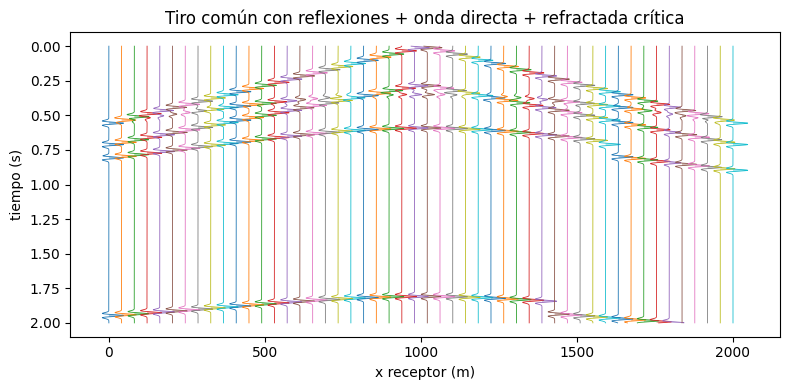

In [21]:
# Ejecutemos el tiro común con directa y refractada
rec_total = shot_gather_with_direct_refrac(gm, v_eff=v_eff, xs=xs, xr=xr, dt=dt, tmax=tmax, f0=f0,
                                           amp_directa=0.6, amp_refrac=0.5, agc_win=121)

t2 = np.arange(rec_total.shape[0]) * dt
plt.figure(figsize=(8,4))
wiggle(rec_total, x=xr, t=t2, scale=amplitud, fill=True, dx=8)
plt.gca().invert_yaxis()
plt.xlabel('x receptor (m)'); plt.ylabel('tiempo (s)')
plt.title('Tiro común con reflexiones + onda directa + refractada crítica')
plt.tight_layout(); plt.show()


## **Ground roll** (onda de suelo) 

Son ondas superficiales (Rayleigh/Love) de baja frecuencia y baja velocidad aparente; gran amplitud, dispersivas, coherentes horizontalmente. Es ruido coherente que contamina tiros terrestres. 

En el sintético se ve una línea de baja velocidad y baja frecuencia. Esto enmascara reflexiones someras.

En campo real es Dominante en offsets cortos y tiempos tempranos; puede ocultar reflectores someros.

Mitigación: Adquisición: arreglo de geófonos, offsets mínimos, filtros analógicos. Procesamiento: filtros f–k (cono de baja velocidad), 

En esta sección añadimos un **ruido coherente superficial** (ground roll), 

### Qué haremos
**Inyectar ground roll** sintético (no dispersivo y *dispersivo* simple) sobre el **tiro común**.



In [24]:
import numpy as np

def add_ground_roll(xs, xr, dt, nt, v_gr=300.0, f0_gr=8.0, amp=1.0, dispersive=False):
    """Genera una matriz (nt x nxr) con ground roll sintético como impulsos sobre t=|x_r-x_s|/v_gr
    y los filtra con Ricker de baja frecuencia. Si 'dispersive'=True, suma 2–3 componentes
    con distintas velocidades y frecuencias para simular dispersión.

    Devuelve: matriz (nt x nxr) para sumar al registro.
    """
    nxr = len(xr)
    gr_imp = np.zeros((nt, nxr))

    if not dispersive:
        # no dispersivo: una sola rama
        for j in range(nxr):
            t_gr = abs(xr[j] - xs) / v_gr
            it = int(round(t_gr / dt))
            if 0 <= it < nt:
                gr_imp[it, j] += amp
        # Ricker baja frecuencia
        tlen = min(201, nt//2*2+1)
        w = ricker(f0_gr, dt, tlen)
        return convolve_traces(gr_imp, w)
    else:
        # dispersivo: suma de varias ramas (f0 y v cambian)
        comps = [(6.0, v_gr*0.8, amp*0.7),
                 (9.0, v_gr*1.0, amp*0.5),
                 (12.0, v_gr*1.3, amp*0.4)]
        out = np.zeros((nt, nxr))
        for f0_c, v_c, a_c in comps:
            tmp = np.zeros((nt, nxr))
            for j in range(nxr):
                t_gr = abs(xr[j] - xs) / v_c
                it = int(round(t_gr / dt))
                if 0 <= it < nt:
                    tmp[it, j] += a_c
            tlen = min(201, nt//2*2+1)
            w = ricker(f0_c, dt, tlen)
            out += convolve_traces(tmp, w)
        return out

def apply_attenuation(traces, dt, geom=True, Q=None, f_c=None):
    """Aplica atenuación dependiente del tiempo:

    - geom=True → factor geométrico ~ 1/sqrt(t)

    - Q (opcional) con frecuencia efectiva f_c → exp(-alpha*t), alpha=pi*f_c/Q

    Devuelve: nueva matriz atenuada.

    """
    nt, nx = traces.shape
    t = np.arange(nt) * dt
    out = traces.copy()
    eps = 1e-6
    if geom:
        geo = 1.0 / np.sqrt(t + eps)
        out = out * geo[:, None]
    if Q is not None and f_c is not None and Q > 0:
        alpha = np.pi * f_c / Q
        anel = np.exp(-alpha * t)
        out = out * anel[:, None]
    return out

def fk_mute_low_velocity(traces, dt, dx, vmin, taper=0.1):
    """Mute en f–k para eliminar energía con velocidad de fase v < vmin.

    - FFT 2D (t,x) → (f,kx); máscara según v_phase = 2π f / |kx| < vmin.

    - 'taper' define franja de transición relativa.

    Devuelve: trazas filtradas (real).

    """
    nt, nx = traces.shape
    # FFT en tiempo y espacio
    TR = np.fft.fft2(traces, s=(nt, nx))
    f = np.fft.fftfreq(nt, d=dt)      # Hz
    kx = np.fft.fftfreq(nx, d=dx) * 2*np.pi  # rad/m
    F, KX = np.meshgrid(f, kx, indexing='xy')  # (nx, nt) si no cuidamos; rehagamos para (nt,nx)
    # Queremos F (nt, nx) y KX (nt, nx)
    F = np.fft.fftfreq(nt, d=dt)[:, None]      # (nt,1)
    KX = (np.fft.fftfreq(nx, d=dx) * 2*np.pi)[None, :]  # (1,nx)
    F_mat = np.tile(F, (1, nx))   # (nt,nx)
    K_mat = np.tile(KX, (nt, 1))  # (nt,nx)

    eps = 1e-9
    v_phase = (2*np.pi*np.abs(F_mat)) / (np.abs(K_mat) + eps)  # m/s
    # Máscara: mantener solo v_phase >= vmin (mute bajas velocidades)
    mask = np.ones_like(v_phase)
    hard = v_phase >= vmin
    soft = (v_phase >= vmin*(1-taper)) & (v_phase < vmin)
    mask[~hard & ~soft] = 0.0
    # Taper lineal en zona soft
    mask[soft] = (v_phase[soft] - vmin*(1-taper)) / (vmin*taper)

    # Aplicar máscara respetando simetría conjugada
    TR_filtered = TR * mask
    out = np.fft.ifft2(TR_filtered).real
    return out


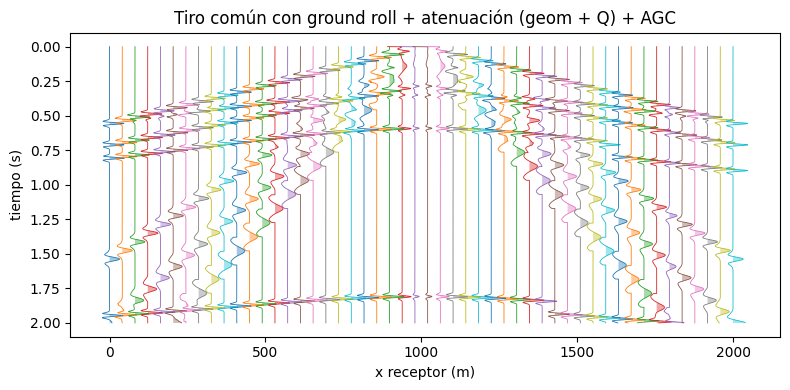

In [44]:
# Parámetros para ground roll y atenuación
v_gr = 500.0         # m/s (velocidad aparente baja)
f0_gr = 8.0          # Hz (baja frecuencia)
amp_gr = 1.0         # amplitud relativa
use_dispersive = True

# Construir ground roll
nt = int(tmax / dt) + 1
gr = add_ground_roll(xs, xr, dt, nt, v_gr=v_gr, f0_gr=f0_gr, amp=amp_gr, dispersive=use_dispersive)

# Registro base con reflexiones (y directa/refractada si ya las sumaste en 'rec_total')
# Si no existe 'rec_total', usamos 'sg' (solo reflexiones del tiro común)
try:
    base = rec_total.copy()
except NameError:
    base = sg.copy()

reg_con_gr = base + gr

# Atenuación (antes de AGC): geométrica + Q
Q = 120.0
f_c = f0  # aproximamos con frecuencia pico de la Ricker principal
reg_atenuado = apply_attenuation(reg_con_gr, dt, geom=True, Q=Q, f_c=f_c)

# AGC para visualización
reg_agc = agc(reg_atenuado, win=121)

# Graficar
t = np.arange(nt) * dt
plt.figure(figsize=(8,4))
wiggle(reg_agc, x=xr, t=t, scale=amplitud, fill=True, dx=8)
plt.gca().invert_yaxis()
plt.xlabel('x receptor (m)'); plt.ylabel('tiempo (s)')
plt.title('Tiro común con ground roll + atenuación (geom + Q) + AGC')
plt.tight_layout(); plt.show()


## Experimentos sugeridos
1. Cambia geometría (sinclinal, capa inclinada extra). ¿Cómo cambia la sección?
2. Mueve la falla y el salto. Observa continuidad de reflectores.
3. Varía \(v_{eff}\). Observa la curvatura de hipérbolas.
4. Cambia \(f_0\) (Ricker). Compara alta vs. baja frecuencia.
5. Cambia amplitud de directa/refractada. ¿Cuándo dominan?
